In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import h5py
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report


%matplotlib inline

**Loading data**

In [4]:
# Open the file as readonly
h5f = h5py.File('/content/drive/My Drive/Colab/SVHN_single_grey1.h5', 'r')
print(list(h5f.keys()))

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close the file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']
Training set (42000, 32, 32) (42000,)
Validation set (60000, 32, 32) (60000,)
Test set (18000, 32, 32) (18000,)


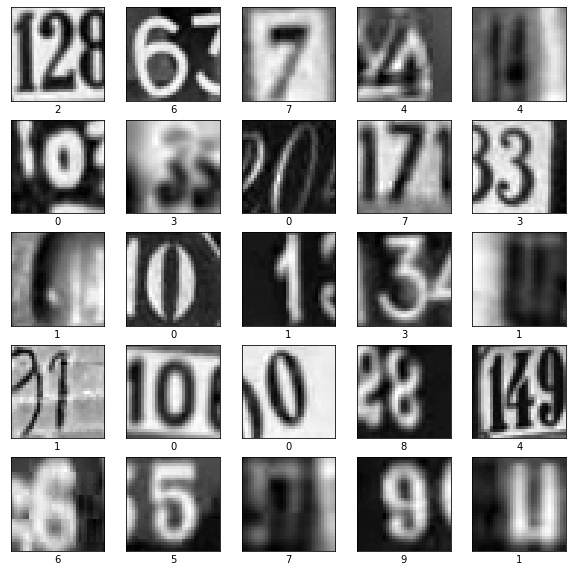

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [6]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

We have 10 unique targets. Lets encode them.

In [0]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)
y_val =  tf.keras.utils.to_categorical(y_val, num_classes = 10)

In [0]:
# Lets flatten out all images and normalise them
Xtr_rows = X_train.reshape(X_train.shape[0], 32 * 32)
Xtr_rows = Xtr_rows.astype('float32')
Xtr_rows_normalized = Xtr_rows / 255.0
Xte_rows = X_test.reshape(X_test.shape[0], 32 * 32 )
Xte_rows = Xte_rows.astype('float32')
Xte_rows_normalized = Xte_rows / 255.0
Xval_rows = X_val.reshape(X_val.shape[0], 32 * 32)
Xval_rows = Xval_rows.astype('float32')
Xval_rows_normalized = Xval_rows / 255.0

Since the validation dataset is huge ,we shall take first 4000 records from that and work on finding the optimal K

In [0]:
Xval_rows_trimmed = Xtr_rows_normalized[:4000, :] 
y_val_trimmed = y_train[:4000]

In [10]:
maxK = int(np.sqrt(Xval_rows_trimmed.shape[0]))
maxK

63

**Finding optimal k**

In [11]:
optimalK = 0
optimalTrainAccuracy = 0
validation_accuracies = []
for k in [3, 5, 10, 20, 50, 100]:

  NNH = KNeighborsClassifier(n_neighbors=k)
  NNH.fit(Xval_rows_trimmed, y_val_trimmed)
  modelScore = NNH.score(Xval_rows_trimmed, y_val_trimmed)
  if((modelScore > optimalTrainAccuracy) and (k > 1)):
    
    optimalK = k
    optimalTrainAccuracy = modelScore
    
print("optimal",(optimalK, optimalTrainAccuracy))

optimal (3, 0.45225)


**Implement and apply an optimal k-Nearest Neighbor (kNN) classifier**

In [12]:
# Nearest Neighbour model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(Xtr_rows_normalized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [13]:
y_predict = knn_model.predict(Xte_rows_normalized)
knnmodel_acc = metrics.accuracy_score(y_test, y_predict) 
print("knn model accuracy",knnmodel_acc)

knn model accuracy 0.3783888888888889


**Print the classification metric report**

In [14]:
print("EVALUATION ON TESTING DATA")
print(classification_report(y_test, y_predict))

y_test = np.array(y_test)
print ("Confusion matrix")
print(multilabel_confusion_matrix(y_test, y_predict))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.61      0.44      0.51      1814
           1       0.62      0.51      0.56      1828
           2       0.74      0.40      0.52      1803
           3       0.56      0.27      0.37      1719
           4       0.78      0.51      0.61      1812
           5       0.58      0.25      0.35      1768
           6       0.54      0.29      0.37      1832
           7       0.80      0.54      0.65      1808
           8       0.45      0.25      0.32      1812
           9       0.60      0.32      0.41      1804

   micro avg       0.64      0.38      0.47     18000
   macro avg       0.63      0.38      0.47     18000
weighted avg       0.63      0.38      0.47     18000
 samples avg       0.38      0.38      0.38     18000

Confusion matrix
[[[15674   512]
  [ 1014   800]]

 [[15604   568]
  [  888   940]]

 [[15947   250]
  [ 1090   713]]

 [[15912   369]
  [ 1248   471]]

 [[1593

**KNN model Summary**

the CNN model has achieved a very less accuracy score of 38% while building a classifier for image

**Implement and apply a deep neural network classifier including (feedforward neural network, RELU activations)**

In [15]:
# input image dimensions
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

#Keras expects data to be in the format (N_E.N_H,N_W,N_C)
#N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.

x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print(x_train.shape)
print(X_test.shape)

(42000, 32, 32, 1)
(18000, 32, 32, 1)


In [21]:
# Initialize Sequential model
model = tf.keras.models.Sequential()

# Reshape data from 2D to 1D -> 28x28 to 784
model.add(tf.keras.layers.Reshape((img_rows*img_cols,),input_shape=input_shape))

# Hidden layers
model.add(tf.keras.layers.Dense(200, activation='relu', name='Layer_1'))
model.add(tf.keras.layers.Dense(100, activation='relu', name='Layer_2'))
#Output layer
model.add(tf.keras.layers.Dense(10, activation='softmax', name='Output'))

#Compiling the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
Layer_1 (Dense)              (None, 200)               205000    
_________________________________________________________________
Layer_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
Output (Dense)               (None, 10)                1010      
Total params: 226,110
Trainable params: 226,110
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x_train, y_train, validation_data=(X_test, y_test), epochs=30,
          batch_size = 32)

Train on 42000 samples, validate on 18000 samples
Epoch 1/30
42000/42000 [==============================] - 5s 127us/sample - loss: 7.7052 - accuracy: 0.1199 - val_loss: 2.4124 - val_accuracy: 0.1754
Epoch 2/30
42000/42000 [==============================] - 5s 116us/sample - loss: 2.2202 - accuracy: 0.1700 - val_loss: 2.1010 - val_accuracy: 0.2149
Epoch 3/30
42000/42000 [==============================] - 5s 117us/sample - loss: 1.9930 - accuracy: 0.2704 - val_loss: 1.8684 - val_accuracy: 0.3544
Epoch 4/30
42000/42000 [==============================] - 5s 121us/sample - loss: 1.7909 - accuracy: 0.3750 - val_loss: 1.5093 - val_accuracy: 0.5003
Epoch 5/30
42000/42000 [==============================] - 5s 120us/sample - loss: 1.5133 - accuracy: 0.4950 - val_loss: 1.4120 - val_accuracy: 0.5282
Epoch 6/30
42000/42000 [==============================] - 5s 111us/sample - loss: 1.3913 - accuracy: 0.5459 - val_loss: 1.3417 - val_accuracy: 0.5683
Epoch 7/30
 9152/42000 [=====>....................

In [0]:
model_loss, model_accuracy = model.evaluate(X_test, y_test)
print("Feedforward neural network, RELU activations",(model_accuracy*100))

18000/18000 [==============================] - 1s 60us/sample - loss: 1.2366 - accuracy: 0.6108
Feedforward neural network, RELU activations 61.08333468437195


In [0]:
y_predict_dnn = model.predict(X_test)

print("EVALUATION ON TESTING DATA")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_predict_dnn, axis=1)))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1814
           1       0.00      0.00      0.00      1828
           2       0.00      0.00      0.00      1803
           3       0.10      1.00      0.17      1719
           4       0.00      0.00      0.00      1812
           5       0.00      0.00      0.00      1768
           6       0.00      0.00      0.00      1832
           7       0.00      0.00      0.00      1808
           8       0.00      0.00      0.00      1812
           9       0.00      0.00      0.00      1804

    accuracy                           0.10     18000
   macro avg       0.01      0.10      0.02     18000
weighted avg       0.01      0.10      0.02     18000



In [0]:
print ("Confusion matrix")
print(multilabel_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_predict_dnn, axis=1)))

Confusion matrix
[[[16186     0]
  [ 1814     0]]

 [[16172     0]
  [ 1828     0]]

 [[16197     0]
  [ 1803     0]]

 [[    0 16281]
  [    0  1719]]

 [[16188     0]
  [ 1812     0]]

 [[16232     0]
  [ 1768     0]]

 [[16168     0]
  [ 1832     0]]

 [[16192     0]
  [ 1808     0]]

 [[16188     0]
  [ 1812     0]]

 [[16196     0]
  [ 1804     0]]]


**Feedforward neural network, RELU activations Summary:**

Feedforward neural network, RELU activations have yielded a accuracy of 65% which is fairly good when compared to KNN

**Understand and be able to implement (vectorized) backpropagation (cost stochastic gradient descent, cross entropy loss, cost functions)**

In [0]:
# Initialize Sequential model
model_sgd = tf.keras.models.Sequential()

# Reshape data from 2D to 1D -> 28x28 to 784
model_sgd.add(tf.keras.layers.Reshape((img_rows*img_cols,),input_shape=input_shape))

# Hidden layers
model_sgd.add(tf.keras.layers.Dense(200, activation='relu', name='Layer_1'))
model_sgd.add(tf.keras.layers.Dense(100, activation='relu', name='Layer_2'))

#Output layer
model_sgd.add(tf.keras.layers.Dense(10, activation='softmax', name='Output'))

#Compiling the Model
optimizedsgd=tf.keras.optimizers.SGD(lr=0.001)
model_sgd.compile(optimizer=optimizedsgd, loss='categorical_crossentropy', metrics=['accuracy'])

#model summary
model_sgd.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1024)              0         
_________________________________________________________________
Layer_1 (Dense)              (None, 200)               205000    
_________________________________________________________________
Layer_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
Output (Dense)               (None, 10)                1010      
Total params: 226,110
Trainable params: 226,110
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_sgd.fit(x_train, y_train, validation_data=(X_test, y_test), epochs=30,
          batch_size = 32)

Train on 42000 samples, validate on 18000 samples
Epoch 1/30
42000/42000 [==============================] - 5s 110us/sample - loss: 5.6276 - accuracy: 0.1001 - val_loss: 2.3067 - val_accuracy: 0.0958
Epoch 2/30
42000/42000 [==============================] - 4s 100us/sample - loss: 2.3029 - accuracy: 0.1021 - val_loss: 2.3057 - val_accuracy: 0.0957
Epoch 3/30
42000/42000 [==============================] - 4s 100us/sample - loss: 2.3024 - accuracy: 0.1022 - val_loss: 2.3058 - val_accuracy: 0.0958
Epoch 4/30
42000/42000 [==============================] - 4s 104us/sample - loss: 2.3021 - accuracy: 0.1021 - val_loss: 2.3055 - val_accuracy: 0.0959
Epoch 5/30
42000/42000 [==============================] - 4s 101us/sample - loss: 2.3020 - accuracy: 0.1021 - val_loss: 2.3055 - val_accuracy: 0.0959
Epoch 6/30
42000/42000 [==============================] - 4s 102us/sample - loss: 2.3020 - accuracy: 0.1022 - val_loss: 2.3055 - val_accuracy: 0.0959
Epoch 7/30
42000/42000 [==========================

KeyboardInterrupt: ignored

In [0]:
modelsgd_loss, modelsgd_accuracy = model_sgd.evaluate(X_test, y_test)
print("SGD neural network, RELU activations",(modelsgd_accuracy*100))

In [0]:
y_predict_sgd = model_sgd.predict(X_test)

print("EVALUATION ON TESTING DATA")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_predict_sgd, axis=1)))

**Deep neural networks with sgd summary**

the model with sgd yielded only 10% accuracy




**Implement batch normalization for training the neural network**

In [0]:
# Initialize Sequential model
model_normalized = tf.keras.models.Sequential()

# Reshape data from 2D to 1D -> 28x28 to 784
model_normalized.add(tf.keras.layers.Reshape((img_rows*img_cols,),input_shape=input_shape))

#Normalize the data
model_normalized.add(tf.keras.layers.BatchNormalization())

# Hidden layers
model_normalized.add(tf.keras.layers.Dense(200, activation='relu', name='Layer_1'))
model_normalized.add(tf.keras.layers.Dense(100, activation='relu', name='Layer_2'))

#Output layer
model_normalized.add(tf.keras.layers.Dense(10, activation='softmax', name='Output'))

#Compile Model
optimizer = tf.keras.optimizers.SGD(lr=0.001, clipvalue=0.5)
model_normalized.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#model summary
model_normalized.summary()

In [0]:
model_normalized.fit(x_train, y_train, validation_data=(X_test, y_test), epochs=30,
          batch_size = 32)

In [0]:
model_normalized_loss, model_normalized_accuracy = model_normalized.evaluate(X_test, y_test)
print("neural network, Batch Normalization",(model_normalized_accuracy*100))

In [0]:
y_predict_normalized = model_normalized.predict(X_test)
print("EVALUATION ON TESTING DATA")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_predict_normalized, axis=1)))

In [0]:
print ("Confusion matrix")
print(multilabel_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_predict_normalized, axis=1)))

**Deep neural networks with batch normalization summary**

the deep neural networks model with batch normalization has yielded a good accuracy of 79%

# Summary
* The KNN model yielded 32% accuracy and the model execution took a lot of time.
* Feedforward neural network, RELU activations has yielded 60% accuracy.
* The sgd neural network has yielded 10% accuracy.
* Batch normalization for training the neural network has yielded 79% accuracy